[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pln-fing-udelar/retuyt-inco-huhu-2023/blob/main/sentence_embeddings/sentence_embeddings.ipynb)

# Using sentence embeddings for the HUHU Shared Task

This notebook presents the sentence embeddings with k-Nearest Neighbors approach used for the HUHU Shared Task at IberLEF 2023. We explore several sentence embeddings models from the [SentenceTransformers](https://www.sbert.net/) package and we compare the results of k-NN with other machine learning techniques.

For this notebook, it is **recommended** to use a runtime with GPU enabled.

The Shared Task consisted of the following three subtasks (as explained in [the official website](https://sites.google.com/view/huhuatiberlef23/huhu)).

### Subtask 1: HUrtful HUmour Detection

The first subtask consists in determining whether a prejudicial tweet is intended to cause humour. Participants will have to distinguish between tweets that using humour express prejudice and tweets that express prejudice without using humour.

### Subtask 2A: Prejudice Target Detection

Taking into account the following minority groups: Women and feminists, LGBTIQ community and Immigrants, racially discriminated people, and overweight people, participants are asked to identify the targeted groups on each tweet as a multilabel classification task.

### Subtask 2B: Degree of Prejudice Prediction

The third subtask consists of predicting on a continuous scale from 1 to 5 to evaluate how prejudicial the message is on average among minority groups.

In [ ]:
#@title Install SentenceTransformers package

!pip install sentence_transformers

In [2]:
#@title Auxiliary functions
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

def plotConfusionMatrix(labels, original, prediction):
    cm = confusion_matrix(original, prediction, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    plt.show()

def getFScorePerClass(labels, original, prediction):

    print("F-Score avg: " + str(round(f1_score(original, prediction, average='macro'), 3)))

    scores = f1_score(original, prediction, average=None, labels=labels)
    for i in range(len(labels)):
        print(f"F-Score for the {labels[i]} class: " + str(round(scores[i], 3)))

To run the following code, it is necessary to have the following files in the root of your directory structure:


*   huhu_split_train.csv
*   huhu_split_dev.csv

In our experiments, we decided to make our own internal 90%-10% split of the training set that was made available by the organizers. This training set can be downloaded from [zenodo](https://zenodo.org/record/7967255).


In [3]:
#@title Load train_set and dev_set
import pandas as pd

train_set = pd.read_csv('huhu_split_train.csv').sample(frac=1, random_state=1).reset_index()
dev_set = pd.read_csv('huhu_split_dev.csv')

In [ ]:
#@title Encode train_set and dev_set tweets
from sentence_transformers import SentenceTransformer

train_tweets = train_set['tweet'].tolist()
dev_tweets = dev_set['tweet'].tolist()

model_name = "cohere-io/gtr-t5-large-1-epoch" #@param ["sentence-transformers/sentence-t5-base", "Maite89/Roberta_finetuning_semantic_similarity_stsb_multi_mt", "symanto/sn-xlm-roberta-base-snli-mnli-anli-xnli", "hiiamsid/sentence_similarity_spanish_es", "sentence-transformers/all-MiniLM-L6-v2", "bigscience/sgpt-bloom-7b1-msmarco", "sentence-transformers/sentence-t5-large", "sentence-transformers/gtr-t5-large", "sentence-transformers/gtr-t5-xl", "cohere-io/gtr-t5-large-1-epoch"] {allow-input: true}

model = SentenceTransformer(model_name)

embeddings_train = model.encode(train_tweets)
embeddings_dev = model.encode(dev_tweets)

## Subtasks 1 and 2A

In [77]:
#@title Select category
category = "humor" #@param ["humor", "prejudice_woman", "prejudice_lgbtiq", "prejudice_inmigrant_race", "gordofobia"]

In [78]:
#@title K-NN classifier
from sklearn.neighbors import KNeighborsClassifier

k = 14 #@param {type: "integer"}
weighted_distance = True #@param {type:"boolean"}

model = KNeighborsClassifier(n_neighbors=k, weights='distance' if weighted_distance else 'uniform')
model.fit(embeddings_train, train_set[category].tolist())

KNeighborsClassifier(n_neighbors=14, weights='distance')

F-Score avg: 0.829
F-Score for the negative class: 0.894
F-Score for the positive class: 0.764


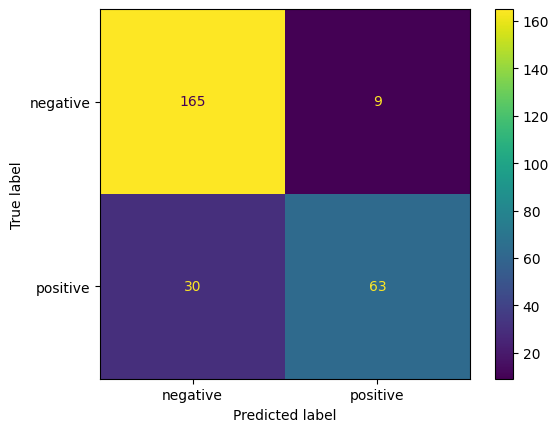

In [79]:
#@title Evaluate classifier
prediction = model.predict(embeddings_dev)

original = ['positive' if x[category] == 1 else 'negative' for _, x in dev_set.iterrows()]
prediction = ['positive' if x == 1 else 'negative' for x in prediction]

getFScorePerClass(['negative','positive'], original, prediction)
plotConfusionMatrix(['negative','positive'], original, prediction)

The following table presents the best results obtained for several SentenceTransformers models, for the subtask 1.

|model| k |weighted_dist|F1 Avg|F1 no_humor|F1 humor|
|:----:|:-:|:-----------:|:----:|:---------:|:------:|
|cohere-io/gtr-t5-xl-1-epoch|14|True|0.829|0.894|0.764|
|sentence-transformers/gtr-t5-large|9|True|0.815|0.886|0.744|
|sentence-transformers/gtr-t5-xl|12|True|0.801|0.879|0.724|
|sentence-transformers/sentence-t5-large|5|False|0.781|0.860|0.702|
|sentence-transformers/sentence-t5-base|12|True|0.761|0.859|0.662|
|sentence-transformers/all-MiniLM-L6-v2|6|True|0.733|0.835|0.630|
|symanto/sn-xlm-roberta-base-snli-mnli-anli-xnli|8|True|0.723|0.848|0.599|
|hiiamsid/sentence_similarity_spanish_es|6|True|0.647|0.830|0.465|
|Maite89/Roberta_finetuning_semantic_similarity_stsb_multi_mt|3|True|0.638|0.813|0.464|

---

These are the results obtained for the subtask 2A using the cohere-io/gtr-t5-large-1-epoch model, k = 3 and waighted_distance = True:

|Clase|F1 Avg|F1 neg|F1 pos|
|:---:|:----:|:----:|:----:|
|prejudice_women|0.933|0.932|0.933|
|prejudice_lgbtiq|0.934|0.971|0.897|
|prejudice_inmigrant_race|0.995|0.998|0.992|
|gordofobia|0.906|0.988|0.824|

### Trying other classifiers

In [89]:
#@title Train classifier
from sklearn import linear_model, tree, naive_bayes, svm, neural_network, preprocessing
import numpy as np

classifier = "SVM" #@param ["SVM", "Decision tree", "Logistic regression", "MLP neural net"]
if classifier == "SVM":
  model = svm.SVC()
elif classifier == "Decision tree":
  model = tree.DecisionTreeClassifier()
elif classifier == "Logistic regression":
  model = linear_model.LogisticRegression()
else:
  model = neural_network.MLPClassifier(hidden_layer_sizes=(50,15,5), random_state=1234, max_iter=1000)

model.fit(embeddings_train, train_set[category].tolist())

SVC()

F-Score avg: 0.792
F-Score for the negative class: 0.873
F-Score for the positive class: 0.712


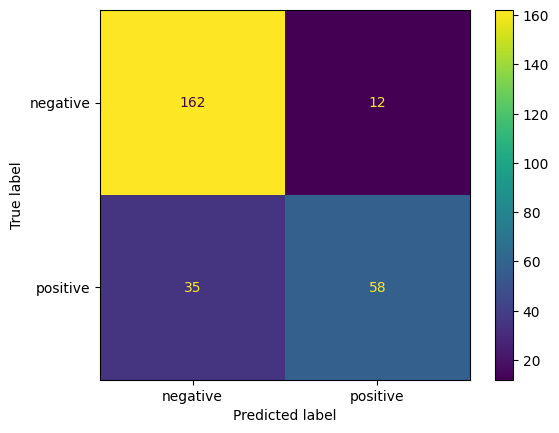

In [90]:
#@title Evaluate classifier
prediction = model.predict(embeddings_dev)

original = ['positive' if x[category] == 1 else 'negative' for _, x in dev_set.iterrows()]
prediction = ['positive' if x == 1 else 'negative' for x in prediction]

getFScorePerClass(['negative','positive'], original, prediction)
plotConfusionMatrix(['negative','positive'], original, prediction)

### Class centroids

In [82]:
#@title Create centroids
import numpy as np

cls = train_set[category].tolist()
pairs = [(embeddings_train[i], cls[i]) for i in range(len(embeddings_train))]
pos = [p[0] for p in pairs if p[1] == 1]
neg = [p[0] for p in pairs if p[1] == 0]

centroid_pos = np.mean(pos, axis=0)
centroid_neg = np.mean(neg, axis=0)

F-Score avg: 0.8
F-Score for the negative class: 0.85
F-Score for the positive class: 0.75


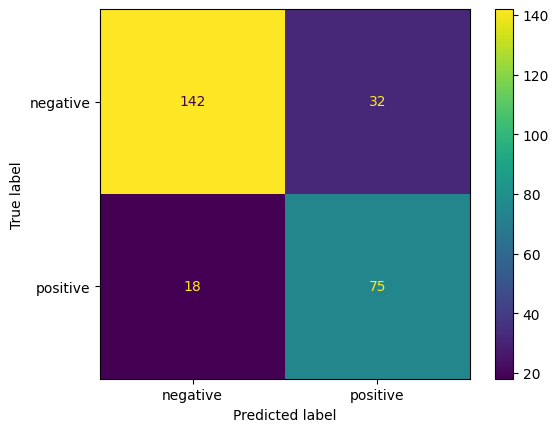

In [83]:
#@title Evaluate classifier
from sklearn import metrics

def compare(v1, v2):
  return metrics.pairwise.cosine_similarity(v1.reshape(1, -1), v2.reshape(1, -1))

prediction = ['positive' if compare(v, centroid_pos) > compare(v, centroid_neg) else 'negative' for v in embeddings_dev]
original = ['positive' if x[category] == 1 else 'negative' for _, x in dev_set.iterrows()]

getFScorePerClass(['negative','positive'], original, prediction)
plotConfusionMatrix(['negative','positive'], original, prediction)

### Results

The following table shows the F1 score for subtask 1 obtained for each classifier, using sentence-transformers/gtr-t5-large as the model for generating the sentence embeddings.

|Classifier|F1 Avg|no_humor F1|humor F1|
|:----------:|:----:|:---------:|:------:|
|k-NN|0.829|0.894|0.764|
|Neural network|0.813|0.872|0.754|
|Logistic Regression|0.807|0.885|0.730|
|Class centroids|0.800|0.850|0.750|
|SVM|0.792|0.873|0.712|
|Decision Tree|0.636|0.742|0.529|

---

The following table presents the results obtained for subtask 2A.

|Class|Classifier|F1 Avg|F1 neg|F1 pos|
|:---:|:----------:|:----:|:----:|:----:|
|prejudice_women|k-NN|0.933|0.932|0.933|
|prejudice_women|Logistic Regression|0.903|0.905|0.900|
|prejudice_women|SVM|0.891|0.895|0.888|
|prejudice_women|Neural Network|0.891|0.891|0.892|
|prejudice_women|Class centroids|0.869|0.875|0.863|
||
|prejudice_lgbtiq|k-NN|0.934|0.971|0.897|
|prejudice_lgbtiq|SVM|0.914|0.965|0.862|
|prejudice_lgbtiq|Neural Network|0.891|0.952|0.831|
|prejudice_lgbtiq|Logistic Regression|0.886|0.956|0.816|
|prejudice_lgbtiq|Class centroids|0.882|0.950|0.814|
||
|prejudice_inmigrant_race|k-NN|0.995|0.998|0.992|
|prejudice_inmigrant_race|SVM|0.990|0.995|0.984|
|prejudice_inmigrant_race|Logistic Regression|0.979|0.990|0.968|
|prejudice_inmigrant_race|Neural Network|0.974|0.988|0.961|
|prejudice_inmigrant_race|Class centroids|0.937|0.967|0.906|
||
|gordofobia|SVM|0.919|0.990|0.849|
|gordofobia|k-NN|0.906|0.988|0.824|
|gordofobia|Neural Network|0.887|0.984|0.790|
|gordofobia|Logistic Regression|0.782|0.980|0.583|
|gordofobia|Class centroids|0.759|0.952|0.566|

## Subtask 2B

Given the regression nature of this task, we used the regression versions of each machine learning technique.

In [91]:
#@title Train model
from sklearn import linear_model, neural_network, svm, neighbors

model = "K-NN regressor" #@param ["K-NN regressor", "Linear regression", "MLP neural net", "SVR"]

if model == "K-NN regressor":
  model = neighbors.KNeighborsRegressor(n_neighbors=11, weights='distance')
elif model == "Linear regression":
  model = linear_model.LinearRegression()
elif model == "MLP neural net":
  model = neural_network.MLPRegressor(hidden_layer_sizes=(10,2,), random_state=1234, max_iter=1000)
else:
  model = svm.SVR()

model.fit(embeddings_train, train_set["mean_prejudice"].tolist())

KNeighborsRegressor(n_neighbors=11, weights='distance')

In [92]:
#@title Evaluate model
from sklearn.metrics import mean_squared_error

prediction = model.predict(embeddings_dev)

original = [x["mean_prejudice"] for _, x in dev_set.iterrows()]

print("RMSE:", mean_squared_error(original, prediction, squared=False))

RMSE: 0.6642409442452981


### Results

The following table shows the RMSE obtained with each technique, using sentence-transformers/gtr-t5-large as the model for generating the sentence embeddings.

|Technique|RMSE|
|:-----:|:--:|
|K-NN Regressor|0.664|
|SVR|0.698|
|MLP Neural Network|0.729|
|Linear Regression|0.779|